## Libs and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import os, sys
import io
from PIL import Image
import json
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read Data

### Transform and load Data

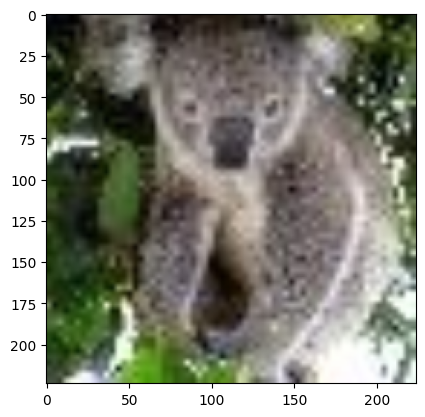

In [3]:
# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 256x256
    # transforms.CenterCrop(224),     # Crop the center 224x224 portion of the image
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define the root directory where your dataset is stored
data_dir = 'data/'

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader to efficiently load and iterate over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Checking a sample batch and dataloader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # denormalize
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out)

## Define NN

In [4]:
from torchvision.models import vgg16
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg16(weights='IMAGENET1K_V1')
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:30]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = self.avg_pool(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [5]:
model = VGG()
model.eval()
output = model(inputs)
probabilities = F.softmax(output, dim=1)

# Load the ImageNet class labels
with open('imagenet_class_index.json', 'r') as f:
    imagenet_class_index = json.load(f)

In [6]:
for images, labels in dataloader:
    output = model(images)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.argmax(probabilities, axis=1)
    predicted_classes_names = [imagenet_class_index[str(predicted_classes[i].item())][1] for i in range(len(predicted_classes))]
    for i in range(len(predicted_classes)):
        print(f"Prediction {i+1}: Class: {predicted_classes[i]}, Class name: {predicted_classes_names[i]}, Probability: {torch.max(probabilities[i]):.5f}")

Prediction 1: Class: 105, Class name: koala, Probability: 0.38535
Prediction 1: Class: 291, Class name: lion, Probability: 0.99633
Prediction 1: Class: 294, Class name: brown_bear, Probability: 0.94924
Prediction 1: Class: 301, Class name: ladybug, Probability: 0.78545
Prediction 1: Class: 341, Class name: hog, Probability: 0.99833
Prediction 1: Class: 447, Class name: binoculars, Probability: 0.99992


In [7]:
pred_classes = np.array([105, 291, 294, 301, 341, 447])

## Gradient Based Pixel Attribution

### GRAD-CAM

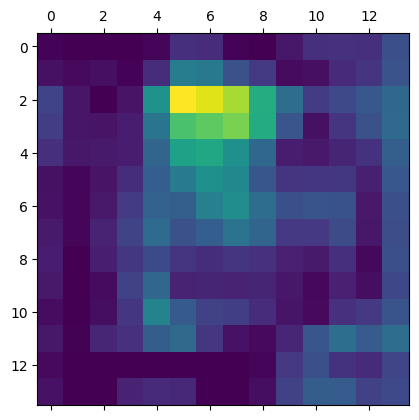

In [8]:
modelgc = VGG()
modelgc.eval()

def get_saliency(inputs, model, predicted_class):
    # get the gradient of the output with respect to the parameters of the model
    pred = model(inputs)
    pred[:, predicted_class].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(inputs).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    return heatmap
heatmap = get_saliency(inputs, modelgc, pred_classes[0])
# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

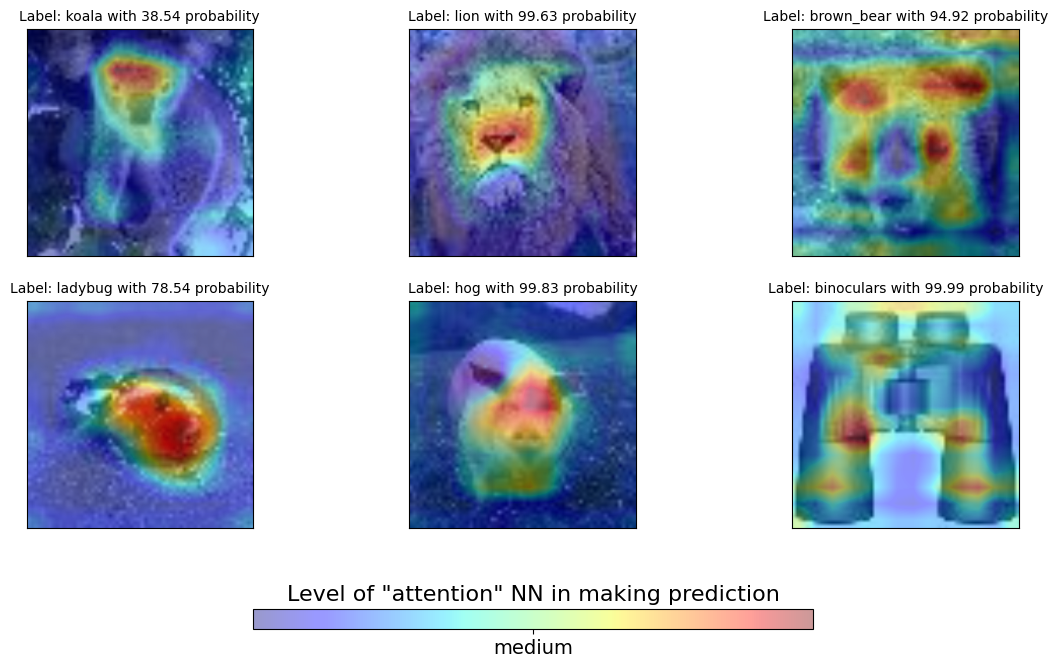

In [9]:
fig=plt.figure(figsize=(14,10))
i = 0
for images, labels in dataloader:
    output = modelgc(images)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.argmax(probabilities, axis=1)
    mask = get_saliency(images, modelgc, pred_classes[i])
    mask = cv2.resize(mask.numpy(), (224, 224))
    ax = fig.add_subplot(3, 3,i +1,xticks=[], yticks=[])
    image = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(image.numpy().transpose((1, 2, 0)))
    plt.imshow(mask, alpha=0.4, cmap='jet')
    ax.set_title('Label: %s with %.2f probability' % (imagenet_class_index[str(predicted_classes.item())][1], torch.max(probabilities).item()*100),fontsize=10)
    i += 1
cax = fig.add_axes([0.32, 0.28, 0.4, 0.02]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=16)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=14)
plt.show()

## Guided BackPropagation

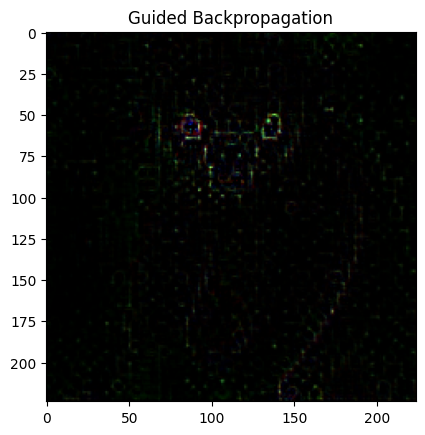

In [10]:
# Load the pre-trained VGG16 model
modelgb = vgg16(weights='IMAGENET1K_V1')
modelgb.eval()

# Define a custom ReLU function for guided backpropagation
class GuidedReLU(nn.Module):
    def forward(self, input):
        return torch.clamp(input, min=0.0)

# Replace all ReLU activations in the model with GuidedReLU
def replace_relu_with_guided(model):
    for module_name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, module_name, GuidedReLU())
        else:
            replace_relu_with_guided(module)

replace_relu_with_guided(modelgb)

# Register hooks to modify the gradient flow
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, GuidedReLU):
        return (torch.clamp(grad_in[0], min=0.0),)

for module in modelgb.modules():
    if isinstance(module, GuidedReLU):
        module.register_backward_hook(relu_hook_function)

# Preprocess the input image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.requires_grad_(True)

# Get the gradients for the target class
def get_guided_backprop_gradients(model, input_img, target_class):
    output = model(input_img)
    model.zero_grad()
    target = output[0][target_class]
    target.backward()
    return input_img.grad.data

# Load and preprocess the image
inputs, classes = next(iter(dataloader))


# Get the guided backpropagation gradients
gradients = get_guided_backprop_gradients(modelgb, inputs.requires_grad_(True), pred_classes[0])

# Convert the gradients to a numpy array and visualize them
gradients = gradients.squeeze().cpu().numpy()
gradients = np.maximum(gradients, 0)
gradients /= gradients.max()

# Plot the gradients
plt.imshow(np.transpose(gradients, (1, 2, 0)))
plt.title('Guided Backpropagation')
plt.show()


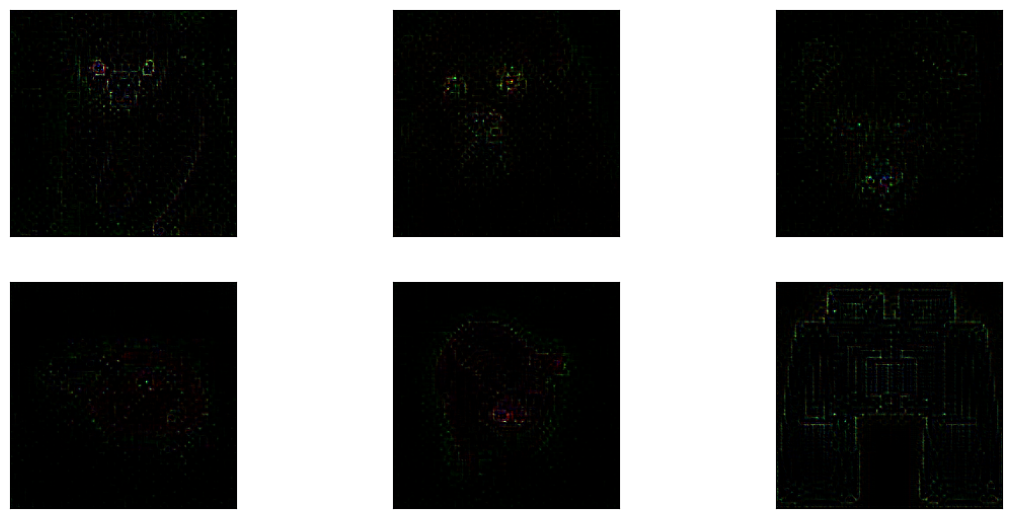

In [21]:
fig=plt.figure(figsize=(14,10))
i = 0
predicted_classes
for images, labels in dataloader:
    gradients = get_guided_backprop_gradients(modelgb, images.requires_grad_(True), pred_classes[i])

    # Convert the gradients to a numpy array and visualize them
    gradients = gradients.squeeze().cpu().numpy()
    gradients = np.maximum(gradients, 0)
    gradients /= gradients.max()
    ax = fig.add_subplot(3, 3,i +1,xticks=[], yticks=[])
    image = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(np.transpose(gradients, (1, 2, 0)))
    # ax.set_title('Label: ' % (imagenet_class_index[str(pred_classes[i])][1]),fontsize=10)
    i += 1
plt.show()

## Guided Grad CAM

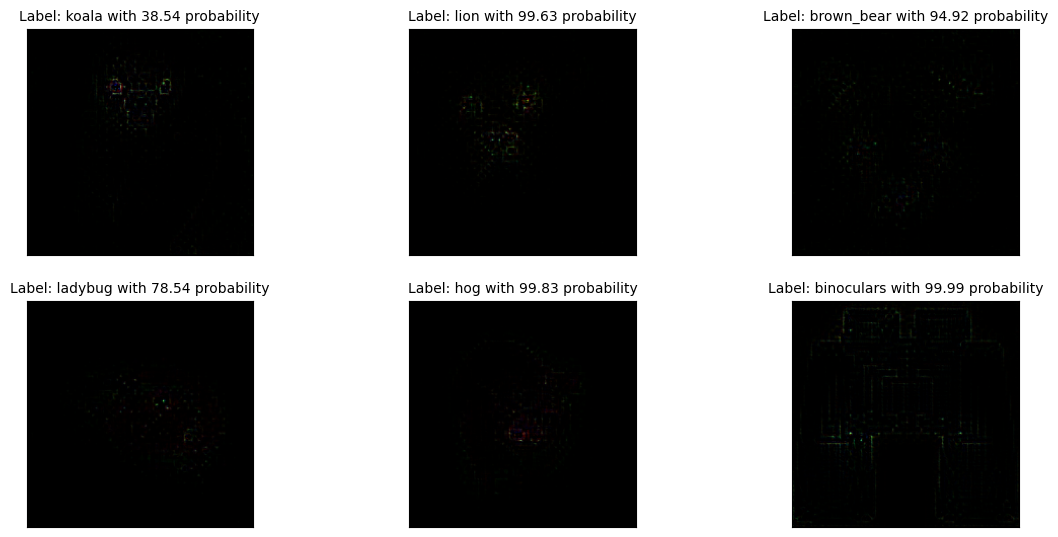

In [23]:
fig=plt.figure(figsize=(14,10))
i = 0
for images, labels in dataloader:
    output = modelgc(images)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.argmax(probabilities, axis=1)
    mask = get_saliency(images, modelgc, pred_classes[i])
    gc = cv2.resize(mask.numpy(), (224, 224))
    gradients = get_guided_backprop_gradients(modelgb, images.requires_grad_(True), pred_classes[i])
    # Convert the gradients to a numpy array and visualize them
    gradients = gradients.squeeze().cpu().numpy()
    gradients = np.maximum(gradients, 0)
    gradients /= gradients.max()
    ax = fig.add_subplot(3, 3,i +1,xticks=[], yticks=[])
    smap = np.multiply(np.expand_dims(gc, axis=2), np.transpose(gradients, (1, 2, 0)))
    plt.imshow(smap)
    ax.set_title('Label: %s with %.2f probability' % (imagenet_class_index[str(predicted_classes.item())][1], torch.max(probabilities).item()*100),fontsize=10)
    i += 1
plt.show()

## Smooth Grad

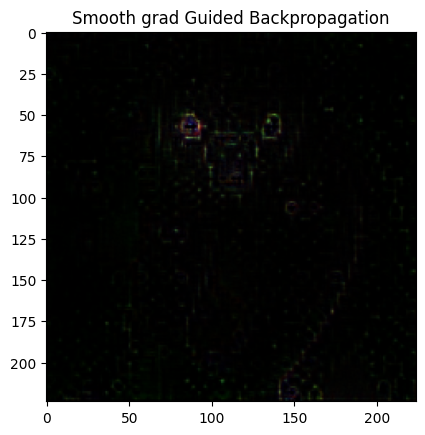

In [13]:
i = 0
smaps = []
# Load and preprocess the image
inputs, classes = next(iter(dataloader))
for n in range(50):
    noise = 0.07 * torch.randn_like(images)
    noisy_image = inputs + noise

    # Get the guided backpropagation gradients
    gradients = get_guided_backprop_gradients(modelgb, noisy_image.requires_grad_(True), pred_classes[0])

    # Convert the gradients to a numpy array and visualize them
    gradients = gradients.squeeze().cpu().numpy()
    gradients = np.maximum(gradients, 0)
    gradients /= gradients.max()
    smaps.append(gradients)
# Plot the gradients
gradients = np.stack(smaps, axis=0)
mean_gradients = np.mean(gradients, axis=0)
plt.imshow(np.transpose(mean_gradients, (1, 2, 0)))
plt.title('Smooth grad Guided Backpropagation')
plt.show()

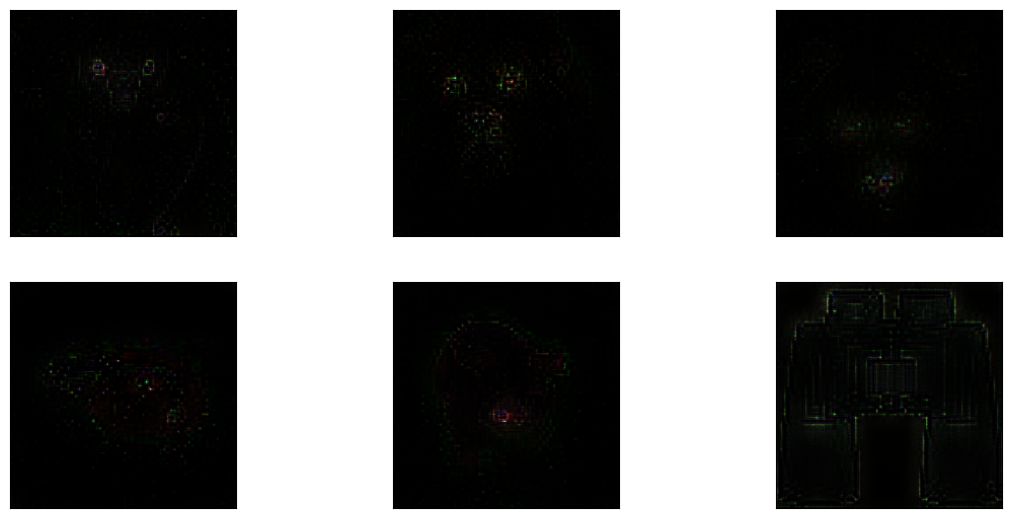

In [25]:
fig=plt.figure(figsize=(14,10))
i = 0
for images, labels in dataloader:
    smaps = []
    for n in range(50):
        noise = 0.1 * torch.randn_like(images)
        noisy_image = images + noise
        # Get the guided backpropagation gradients
        gradients = get_guided_backprop_gradients(modelgb, noisy_image.requires_grad_(True), pred_classes[0])
        # Convert the gradients to a numpy array and visualize them
        gradients = gradients.squeeze().cpu().numpy()
        gradients = np.maximum(gradients, 0)
        gradients /= gradients.max()
        smaps.append(gradients)
    # Plot the gradients
    gradients = np.stack(smaps, axis=0)
    mean_gradients = np.mean(gradients, axis=0)
    ax = fig.add_subplot(3, 3,i +1,xticks=[], yticks=[])
    plt.imshow(np.transpose(mean_gradients, (1, 2, 0)))
    i += 1
plt.show()

## Smooth Grad + gradCAM

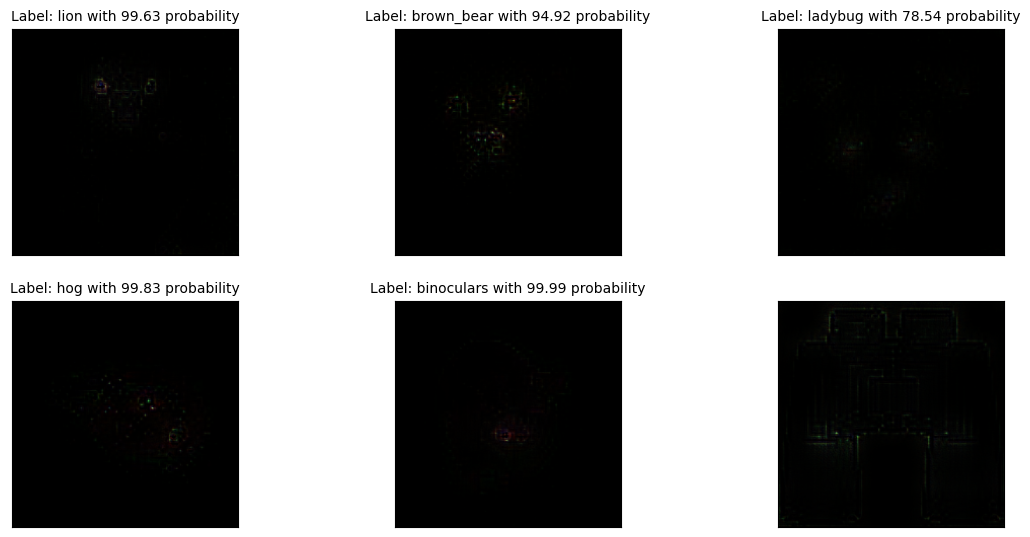

In [27]:
fig=plt.figure(figsize=(14,10))
i = 0
for images, labels in dataloader:
    smaps = []
    output = modelgc(images)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.argmax(probabilities, axis=1)
    mask = get_saliency(images, modelgc, pred_classes[i])
    gc = cv2.resize(mask.numpy(), (224, 224))
    for n in range(50):
        noise = 0.1 * torch.randn_like(images)
        noisy_image = images + noise
        # Get the guided backpropagation gradients
        gradients = get_guided_backprop_gradients(modelgb, noisy_image.requires_grad_(True), pred_classes[0])
        # Convert the gradients to a numpy array and visualize them
        gradients = gradients.squeeze().cpu().numpy()
        gradients = np.maximum(gradients, 0)
        gradients /= gradients.max()
        smaps.append(gradients)
    # Plot the gradients
    gradients = np.stack(smaps, axis=0)
    mean_gradients = np.mean(gradients, axis=0)
    smap = np.multiply(np.expand_dims(gc, axis=2), np.transpose(mean_gradients, (1, 2, 0)))
    ax.set_title('Label: %s with %.2f probability' % (imagenet_class_index[str(predicted_classes.item())][1], torch.max(probabilities).item()*100),fontsize=10)
    ax = fig.add_subplot(3, 3,i +1,xticks=[], yticks=[])
    plt.imshow(smap)
    i += 1
plt.show()

## Adversarial

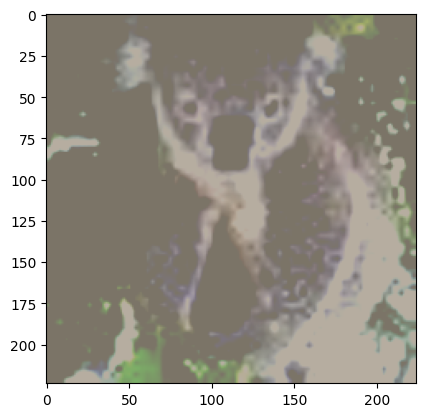

In [16]:
criterion = nn.CrossEntropyLoss()
def fgsm_attack(model, data, target, epsilon=0.01):
    """
    FGSM attack implementation.
    Args:
        model: Your neural network model.
        data: Input data (shape: 1x3xHxW).
        target: True labels for the data.
        epsilon: Perturbation magnitude (maximum allowed L-infinity norm).
    Returns:
        Perturbed data (adversarial example).
    """
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    loss.backward()

    # FGSM update
    perturbed_data = data + epsilon * data.grad.sign()
    perturbed_data = torch.clamp(perturbed_data, min=0, max=1)  # Clip to valid image range

    return perturbed_data

modeladv = vgg16(weights='IMAGENET1K_V1')
modeladv.eval()

data, target = next(iter(dataloader))  # Get a single batch
perturbed_data = fgsm_attack(modeladv, data, torch.tensor([105]))
out = torchvision.utils.make_grid(perturbed_data.squeeze(0).detach())

imshow(out)

In [17]:
output = modeladv(perturbed_data)
probabilities = F.softmax(output, dim=1)
predicted_classes = torch.argmax(probabilities, axis=1)
predicted_classes_names = [imagenet_class_index[str(predicted_classes[i].item())][1] for i in range(len(predicted_classes))]
for i in range(len(predicted_classes)):
    print(f"Prediction {i+1}: Class: {predicted_classes[i]}, Class name: {predicted_classes_names[i]}, Probability: {torch.max(probabilities[i]):.5f}")

Prediction 1: Class: 973, Class name: coral_reef, Probability: 0.34342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


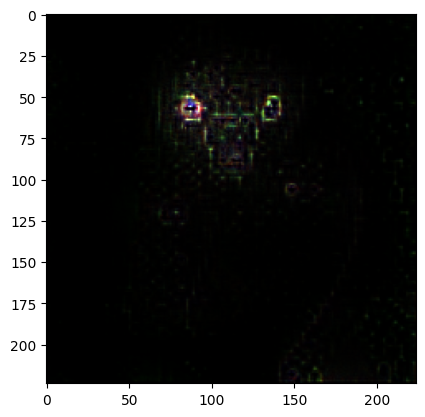

In [18]:
data, target = next(iter(dataloader))
smaps = []

mask = get_saliency(data, modelgc, pred_classes[0])
gc = cv2.resize(mask.numpy(), (224, 224))
for n in range(50):
    noise = 0.1 * torch.randn_like(data)
    noisy_image = data + noise
    # Get the guided backpropagation gradients
    gradients = get_guided_backprop_gradients(modelgb, noisy_image.requires_grad_(True), pred_classes[0])
    # Convert the gradients to a numpy array and visualize them
    gradients = gradients.squeeze().cpu().numpy()
    gradients = np.maximum(gradients, 0)
    gradients /= gradients.max()
    smaps.append(gradients)
# Plot the gradients
gradients = np.stack(smaps, axis=0)
mean_gradients = np.mean(gradients, axis=0)
smap = np.multiply(np.expand_dims(gc, axis=2), np.transpose(mean_gradients, (1, 2, 0)))
plt.imshow(smap*5)
plt.show()

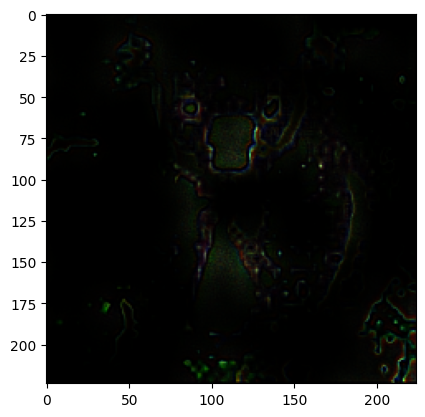

In [19]:
smaps = []
perturbed_data = perturbed_data.detach()
mask = get_saliency(perturbed_data, modelgc, pred_classes[0])
gc = cv2.resize(mask.numpy(), (224, 224))
for n in range(50):
    noise = 0.1 * torch.randn_like(data)
    noisy_image = perturbed_data + noise
    # Get the guided backpropagation gradients
    gradients = get_guided_backprop_gradients(modelgb, noisy_image.requires_grad_(True), pred_classes[0])
    # Convert the gradients to a numpy array and visualize them
    gradients = gradients.squeeze().cpu().numpy()
    gradients = np.maximum(gradients, 0)
    gradients /= gradients.max()
    smaps.append(gradients)
# Plot the gradients
gradients = np.stack(smaps, axis=0)
mean_gradients = np.mean(gradients, axis=0)
smap = np.multiply(np.expand_dims(gc, axis=2), np.transpose(mean_gradients, (1, 2, 0)))
plt.imshow(smap*5)
plt.show()